## First try at getting some data

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [7]:
#Essentials
import numpy as np
import pandas as pd
import pickle
import re
import datetime as dt
import time as t
from termcolor import colored

#SQL related
import psycopg2
import sqlite3
from sqlalchemy import create_engine
import pandas.io.sql as pd_sql

#Visualization
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from  statsmodels.graphics.tsaplots import plot_pacf

#Time series
# from fbprophet import Prophet

#Regression imports
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import feature_selection as f_select
from sklearn.model_selection import cross_val_score
from sklearn.cross_validation import KFold
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import learning_curve


#Nice to have
from sklearn.pipeline import make_pipeline

#Geography magic
import geocoder
# import googlemaps
import geopy.distance as gd
import geopandas as gpd
import shapely
from shapely.geometry import Point

%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 25, 6
rcParams.update({'font.size': 14})

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Load all the data into an SQL database

In [8]:
# Set up the database connection
conn = psycopg2.connect(dbname="taxi_rides_db", user="auste_m")

In [9]:
# taxi_rides_query = """SELECT * FROM taxi_rides WHERE trip_start_timestamp BETWEEN '2016-02-01' AND '2016-02-15';""" 
# weather_query = """SELECT * FROM chicago_weather WHERE date BETWEEN '2016-02-01' AND '2016-02-15';"""

taxi_weather_query = """SELECT TR.trip_start_timestamp,
                                TR.trip_end_timestamp,
                                TR.trip_seconds,
                                TR.trip_miles,
                                --TR.pickup_community_area,
                                --TR.dropoff_community_area,
                                --TR.fare,
                                --TR.tolls,
                                CASE WHEN TR.tolls IS NULL THEN TR.fare ELSE TR.fare + TR.tolls END as fare_with_tolls,
                                --TR.tips,
                                --TR.trip_total,
                                TR.payment_type,
                                TR.pickup_centroid_latitude,
                                TR.pickup_centroid_longitude,
                                TR.pickup_centroid_location,
                                TR.dropoff_centroid_latitude,
                                TR.dropoff_centroid_longitude,
                                TR.dropoff_centroid_location,
                                CW.avg_daily_wind_speed,
                                CW.avg_temp_f,
                                CASE WHEN CW.fog = 1 OR CW.heavy_fog = 1 OR ice_fog = 1 OR mist = 1 THEN 1 ELSE 0 END as fog,
                                CASE WHEN CW.rain = 1 OR CW.drizzle = 1 OR CW.hail = 1 THEN 1 ELSE 0 END as rain,
                                CASE WHEN CW.snow = 1 OR CW.freezing_rain = 1 OR drifting_snow = 1 THEN 1 ELSE 0 END as snow
                                
                        FROM taxi_rides_clean as TR
                        LEFT JOIN chicago_weather as CW
                        ON CAST(TR.trip_start_timestamp AS DATE) = CAST(date AS DATE)
                        WHERE trip_start_timestamp BETWEEN '2017-01-01' AND '2017-02-28'
                        ORDER BY TR.trip_start_timestamp;""" 

In [10]:
#approx. 30min to load the whole of 2016 data
sql_load = pd.read_sql_query(taxi_weather_query, con=conn)

In [11]:
train_set_jan = sql_load[(sql_load['trip_start_timestamp'] >= '2017-01-01 00:00:00') & 
                         (sql_load['trip_start_timestamp'] <= '2017-01-31 23:59:59')]

test_set_feb = sql_load[(sql_load['trip_start_timestamp'] >= '2017-02-01 00:00:00') & 
                         (sql_load['trip_start_timestamp'] < '2017-02-28 23:59:59')]

In [12]:
# taxi_weather_df = sql_load
# taxi_weather_df = sql_load[sql_load['trip_start_timestamp'] <= '2016-12-31 23:59:59']
# test_set_jan = sql_load[(sql_load['trip_start_timestamp'] >= '2017-01-01 00:00:00') & (sql_load['trip_start_timestamp'] < '2017-01-31 23:59:59')]
# test_set_feb = sql_load[(sql_load['trip_start_timestamp'] >= '2017-02-01 00:00:00') & (sql_load['trip_start_timestamp'] < '2017-02-28 23:59:59')]
# test_set_mar = sql_load[(sql_load['trip_start_timestamp'] >= '2017-03-01 00:00:00') & (sql_load['trip_start_timestamp'] < '2017-03-31 23:59:59')]
# test_set_apr = sql_load[(sql_load['trip_start_timestamp'] >= '2017-04-01 00:00:00') & (sql_load['trip_start_timestamp'] < '2017-04-30 23:59:59')]
# test_set_may = sql_load[(sql_load['trip_start_timestamp'] >= '2017-05-01 00:00:00') & (sql_load['trip_start_timestamp'] < '2017-03-31 23:59:59')]
# test_set_jun = sql_load[(sql_load['trip_start_timestamp'] >= '2017-06-01 00:00:00') & (sql_load['trip_start_timestamp'] < '2017-06-30 23:59:59')]
# test_set_jul = sql_load[(sql_load['trip_start_timestamp'] >= '2017-07-01 00:00:00') & (sql_load['trip_start_timestamp'] < '2017-03-31 23:59:59')]

In [13]:
# taxi_weather_df = sql_load.sample(n=75000, random_state=42)

In [14]:
train_set_jan.describe()

,trip_seconds,trip_miles,fare_with_tolls,pickup_centroid_latitude,pickup_centroid_longitude,dropoff_centroid_latitude,dropoff_centroid_longitude,avg_daily_wind_speed,avg_temp_f,fog,rain,snow
count,1.040186e+06,1.040255e+06,1.040255e+06,943841.000000,943841.000000,925096.000000,925096.000000,1.040262e+06,1.040262e+06,1.040262e+06,1040262.0,1040262.0
mean,7.165514e+02,2.962954e+00,1.294192e+01,41.900391,-87.659718,41.900507,-87.651721,1.042192e+01,2.871399e+01,6.722124e-01,0.0,0.0
std,1.104101e+03,5.276065e+00,3.482515e+01,0.036941,0.074813,0.036213,0.054588,4.148031e+00,1.078390e+01,4.694072e-01,0.0,0.0
min,0.000000e+00,0.000000e+00,0.000000e+00,41.660136,-87.913625,41.660136,-87.913625,2.240000e+00,4.000000e+00,0.000000e+00,0.0,0.0
25%,3.000000e+02,4.000000e-01,6.000000e+00,41.880994,-87.651311,41.880994,-87.655998,7.160000e+00,2.200000e+01,0.000000e+00,0.0,0.0
50%,5.180000e+02,1.100000e+00,7.750000e+00,41.892042,-87.632746,41.892508,-87.633308,1.007000e+01,3.200000e+01,1.000000e+00,0.0,0.0
75%,8.400000e+02,2.570000e+00,1.275000e+01,41.901207,-87.626211,41.907520,-87.626215,1.275000e+01,3.700000e+01,1.000000e+00,0.0,0.0
max,8.634000e+04,1.234000e+03,9.000800e+03,42.015934,-87.534903,42.016046,-87.534903,2.326000e+01,4.800000e+01,1.000000e+00,0.0,0.0


> Original number of records for the whole of 2017 Jan: **943,841**

## Sweeping time!

In [15]:
#Change payment type to boolean
train_set_jan['payment_type'] = pd.Categorical(train_set_jan['payment_type'])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [16]:
#Let's drop all the records with a missing lat / long in either pickup or dropoff
train_set_jan = train_set_jan.dropna(subset=['pickup_centroid_latitude', 'pickup_centroid_longitude', 'dropoff_centroid_latitude'
                                                    , 'dropoff_centroid_longitude', 'trip_seconds', 'trip_miles', 'fare_with_tolls'])

In [17]:
train_set_jan.head(2)

,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,fare_with_tolls,payment_type,pickup_centroid_latitude,pickup_centroid_longitude,pickup_centroid_location,dropoff_centroid_latitude,dropoff_centroid_longitude,dropoff_centroid_location,avg_daily_wind_speed,avg_temp_f,fog,rain,snow
0,2017-01-01,2017-01-01 00:30:00,1320.0,5.8,18.75,Cash,41.878866,-87.625192,POINT (-87.6251921424 41.8788655841),41.878594,-87.730232,POINT (-87.7302324284 41.8785943576),4.92,27,1,0,0
1,2017-01-01,2017-01-01 00:30:00,2160.0,0.0,17.00,Cash,41.880994,-87.632746,POINT (-87.6327464887 41.8809944707),41.892508,-87.626215,POINT (-87.6262149064 41.8925077809),4.92,27,1,0,0


In [18]:
train_set_jan[['fog', 'rain', 'snow']] = train_set_jan[['fog', 'rain', 'snow']].fillna(value=0)

In [19]:
#Let's get rid of the zeroes
train_set_jan = train_set_jan[(train_set_jan['fare_with_tolls'] != 0.0) 
                                          & (train_set_jan['trip_seconds'] != 0.0) 
                                          & (train_set_jan['trip_miles'] != 0.0)]

In [20]:
#Removing clear error records from the dataset (e.g. $1,000 for 0.1 mile and 6 min ride). Settling at max 100 miles an hour
train_set_jan = train_set_jan[(train_set_jan['trip_miles'] / (train_set_jan['trip_seconds'] / 3600.0)) <= 100.0]

In [21]:
#Based on above analysis, I'm setting a max fare/mile at $250 and max fare/minute to $50
train_set_jan = train_set_jan[((train_set_jan['fare_with_tolls'] / train_set_jan['trip_miles']) <= 50) &
                                 ((train_set_jan['fare_with_tolls'] / (train_set_jan['trip_seconds'] / 60.0)) <= 250)]

In [22]:
train_set_jan.count()[0]

717178

> Remaining number of records after cleaning for 2016: **76%** (717,178)

## Predicting the demand

In [23]:
with open('LinearRegression_demand.pkl', 'rb') as pickle_LinReg:
    LR_demand = pickle.load(pickle_LinReg)

In [24]:
train_set_jan.head()

,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,fare_with_tolls,payment_type,pickup_centroid_latitude,pickup_centroid_longitude,pickup_centroid_location,dropoff_centroid_latitude,dropoff_centroid_longitude,dropoff_centroid_location,avg_daily_wind_speed,avg_temp_f,fog,rain,snow
0,2017-01-01,2017-01-01 00:30:00,1320.0,5.8,18.75,Cash,41.878866,-87.625192,POINT (-87.6251921424 41.8788655841),41.878594,-87.730232,POINT (-87.7302324284 41.8785943576),4.92,27,1,0,0
2,2017-01-01,2017-01-01 00:00:00,60.0,0.3,4.00,Cash,41.922686,-87.649489,POINT (-87.6494887289 41.9226862843),41.922686,-87.649489,POINT (-87.6494887289 41.9226862843),4.92,27,1,0,0
3,2017-01-01,2017-01-01 00:00:00,240.0,0.5,4.75,Cash,41.892508,-87.626215,POINT (-87.6262149064 41.8925077809),41.899156,-87.626211,POINT (-87.6262105324 41.8991556134),4.92,27,1,0,0
6,2017-01-01,2017-01-01 00:30:00,1020.0,4.9,15.75,Cash,41.944227,-87.655998,POINT (-87.6559981815 41.9442266014),41.899602,-87.633308,POINT (-87.6333080367 41.899602111),4.92,27,1,0,0
7,2017-01-01,2017-01-01 00:15:00,180.0,0.9,5.25,Cash,42.009623,-87.670167,POINT (-87.6701668569 42.0096228806),42.009623,-87.670167,POINT (-87.6701668569 42.0096228806),4.92,27,1,0,0


In [25]:
#Define the start and end date and time
# start = train_set_jan['trip_start_timestamp'].iloc[0]
# end = train_set_jan['trip_start_timestamp'].iloc[-1]
# print(start)
# print(end)


In [26]:
hist_demand = train_set_jan.groupby(['trip_start_timestamp'])['trip_start_timestamp'].count()
hist_demand_df = pd.DataFrame(hist_demand)
hist_demand_df = hist_demand_df.rename(columns={'trip_start_timestamp': 'interval_demand'})

hist_demand_diff = hist_demand_df.diff()
hist_demand_diff = hist_demand_diff[1:]

In [27]:
hist_demand.head()

trip_start_timestamp
2017-01-01 00:00:00    283
2017-01-01 00:15:00    395
2017-01-01 00:30:00    407
2017-01-01 00:45:00    427
2017-01-01 01:00:00    409
Name: trip_start_timestamp, dtype: int64

In [28]:
hist_demand_diff.head()

,interval_demand
trip_start_timestamp,
2017-01-01 00:15:00,112.0
2017-01-01 00:30:00,12.0
2017-01-01 00:45:00,20.0
2017-01-01 01:00:00,-18.0
2017-01-01 01:15:00,124.0


In [29]:
#Create lags
hist_demand_diff['demand_lag1'] = hist_demand_diff['interval_demand'].shift(1)
hist_demand_diff['demand_lag2'] = hist_demand_diff['interval_demand'].shift(2)
hist_demand_diff['demand_lag3'] = hist_demand_diff['interval_demand'].shift(3)
hist_demand_diff['demand_lag4'] = hist_demand_diff['interval_demand'].shift(4)
hist_demand_diff['demand_lag5'] = hist_demand_diff['interval_demand'].shift(5)
hist_demand_diff['demand_lag6'] = hist_demand_diff['interval_demand'].shift(6)
hist_demand_diff['demand_lag7'] = hist_demand_diff['interval_demand'].shift(7)
hist_demand_diff['demand_lag96'] = hist_demand_diff['interval_demand'].shift(96)
hist_demand_diff['demand_lag672'] = hist_demand_diff['interval_demand'].shift(672)

#Drop rows with NaN values
hist_demand_diff = hist_demand_diff.dropna()

#Drop the interval_demand column
actual_demand_diff = hist_demand_diff['interval_demand']
hist_demand_diff = hist_demand_diff.drop(columns=['interval_demand'])

In [30]:
hist_demand_diff.head()

,demand_lag1,demand_lag2,demand_lag3,demand_lag4,demand_lag5,demand_lag6,demand_lag7,demand_lag96,demand_lag672
trip_start_timestamp,,,,,,,,,
2017-01-08 00:15:00,10.0,15.0,-9.0,-48.0,22.0,15.0,-37.0,-13.0,112.0
2017-01-08 00:30:00,-37.0,10.0,15.0,-9.0,-48.0,22.0,15.0,9.0,12.0
2017-01-08 00:45:00,14.0,-37.0,10.0,15.0,-9.0,-48.0,22.0,-17.0,20.0
2017-01-08 01:00:00,-16.0,14.0,-37.0,10.0,15.0,-9.0,-48.0,-31.0,-18.0
2017-01-08 01:15:00,29.0,-16.0,14.0,-37.0,10.0,15.0,-9.0,59.0,124.0


In [31]:
actual_demand_diff.head()

trip_start_timestamp
2017-01-08 00:15:00   -37.0
2017-01-08 00:30:00    14.0
2017-01-08 00:45:00   -16.0
2017-01-08 01:00:00    29.0
2017-01-08 01:15:00   -31.0
Name: interval_demand, dtype: float64

In [32]:
# historic_demand_diff = get_diffed_demand(get_demand(start, end)) 

## Predicting moment

In [34]:
predicted_demand_jan = LR_demand.predict(hist_demand_diff)

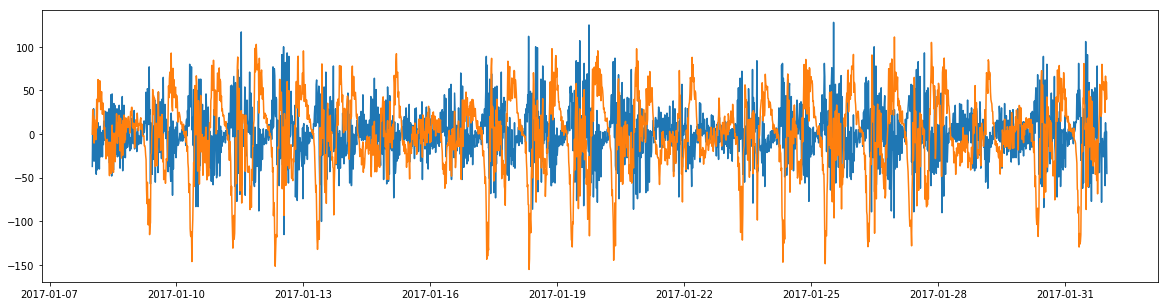

In [35]:
plt.figure(figsize=(20, 5))
plt.plot(hist_demand_diff.index, actual_demand_diff)
plt.plot(hist_demand_diff.index, predicted_demand_jan);

> What the F***!!!

In [36]:
print('RMSE is', str(round(np.sqrt(mean_squared_error(actual_demand_diff, predicted_demand_jan.reshape(-1, 1))), 1)))
print('While the standard deviation of the demand is', str(round(np.std(actual_demand_diff), 1)))

RMSE is 55.0
While the standard deviation of the demand is 30.3


In [37]:
LR_demand.coef_

array([-0.83148945, -0.6614409 , -0.52017488, -0.39271051, -0.28539455,
       -0.18886224, -0.09235116,  0.00802073,  0.00319773])

In [38]:
r2 = LR_demand.score(hist_demand_diff, actual_demand_diff)
print('R-squared is', str(round(r2, 2)))

R-squared is -2.29


In [39]:
hist_demand_diff.iloc[0]

demand_lag1       10.0
demand_lag2       15.0
demand_lag3       -9.0
demand_lag4      -48.0
demand_lag5       22.0
demand_lag6       15.0
demand_lag7      -37.0
demand_lag96     -13.0
demand_lag672    112.0
Name: 2017-01-08 00:15:00, dtype: float64

In [40]:
actual_demand_diff[0]

-37.0

### Predicted demand df

In [43]:
jan_pred_demand = pd.DataFrame(predicted_demand_jan, index=hist_demand_diff.index, columns=['predicted_demand'])
# jan_pred_demand = jan_pred_demand.reset_index()
# jan_pred_demand = jan_pred_demand.set_index(['trip_start_timestamp'])

In [44]:
jan_pred_demand.head()

,predicted_demand
trip_start_timestamp,
2017-01-08 00:15:00,-0.145654
2017-01-08 00:30:00,28.151653
2017-01-08 00:45:00,11.269790
2017-01-08 01:00:00,20.908440
2017-01-08 01:15:00,-10.268356


## Prepare features for modelling

In [45]:
#Adding demand variable in (joining on the trip_start_timestamp)
train_set_jan = train_set_jan.merge(jan_pred_demand, how='left', on='trip_start_timestamp', )
train_set_jan = train_set_jan.dropna()

In [46]:
train_set_jan.head(3)

,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,fare_with_tolls,payment_type,pickup_centroid_latitude,pickup_centroid_longitude,pickup_centroid_location,dropoff_centroid_latitude,dropoff_centroid_longitude,dropoff_centroid_location,avg_daily_wind_speed,avg_temp_f,fog,rain,snow,predicted_demand
149508,2017-01-08 00:15:00,2017-01-08 00:30:00,660.0,2.10,9.25,Credit Card,41.885281,-87.657233,POINT (-87.6572331997 41.8852813201),41.900266,-87.632109,POINT (-87.6321092196 41.9002656868),9.62,9,0,0,0,-0.145654
149509,2017-01-08 00:15:00,2017-01-08 00:15:00,240.0,0.20,4.25,Cash,41.892042,-87.631864,POINT (-87.6318639497 41.8920421365),41.892073,-87.628874,POINT (-87.6288741572 41.8920726347),9.62,9,0,0,0,-0.145654
149510,2017-01-08 00:15:00,2017-01-08 00:45:00,1270.0,6.32,19.50,Credit Card,41.899602,-87.633308,POINT (-87.6333080367 41.899602111),41.947792,-87.683835,POINT (-87.6838349425 41.9477915865),9.62,9,0,0,0,-0.145654


#### Log distance and target variables

In [47]:
#Given previous analysis, miles, seconds and fare variables all have right-skewed distribution, to fix that I'm logging those three variables
train_set_jan['log_trip_miles'] = np.log(train_set_jan['trip_miles'])
train_set_jan['log_trip_seconds'] = np.log(train_set_jan['trip_seconds'])
train_set_jan['log_fare_with_tolls'] = np.log(train_set_jan['fare_with_tolls'])
train_set_jan['pickup_weekday'] = train_set_jan['trip_start_timestamp'].dt.weekday

In [48]:
train_set_jan.head(2)

,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,fare_with_tolls,payment_type,pickup_centroid_latitude,pickup_centroid_longitude,pickup_centroid_location,dropoff_centroid_latitude,...,avg_daily_wind_speed,avg_temp_f,fog,rain,snow,predicted_demand,log_trip_miles,log_trip_seconds,log_fare_with_tolls,pickup_weekday
149508,2017-01-08 00:15:00,2017-01-08 00:30:00,660.0,2.1,9.25,Credit Card,41.885281,-87.657233,POINT (-87.6572331997 41.8852813201),41.900266,...,9.62,9,0,0,0,-0.145654,0.741937,6.492240,2.224624,6
149509,2017-01-08 00:15:00,2017-01-08 00:15:00,240.0,0.2,4.25,Cash,41.892042,-87.631864,POINT (-87.6318639497 41.8920421365),41.892073,...,9.62,9,0,0,0,-0.145654,-1.609438,5.480639,1.446919,6


### Explore exogenious variables

In [213]:
taxi_smaller = train_set_jan[['trip_start_timestamp', 'trip_miles', 'pickup_centroid_latitude', 'pickup_centroid_longitude', 'dropoff_centroid_latitude', 'dropoff_centroid_longitude',
                          'avg_temp_f', 'fog', 'rain', 'snow', 'trip_seconds', 'fare_with_tolls']]

In [214]:
taxi_weather_Sept = taxi_smaller[(taxi_smaller['trip_start_timestamp'] >= '2016-09-01 00:00:00') &
                                         (taxi_smaller['trip_start_timestamp'] <= '2016-09-15 23:59:59')]


In [215]:
#Examine the correlations
# sns.pairplot(taxi_weather_Sept)

### Define features and target

In [49]:
#Define features and target variable for trip duration prediction
feature_space = train_set_jan[['predicted_demand', 'pickup_weekday', 
                                        'log_trip_miles', 'pickup_centroid_latitude', 'pickup_centroid_longitude', 
                                        'dropoff_centroid_latitude', 'dropoff_centroid_longitude',
                                        'avg_daily_wind_speed', 'avg_temp_f', 'fog', 'rain', 'snow']]

#Target variables
target_duration_log = train_set_jan['log_trip_seconds'] 
target_fare_log = train_set_jan['log_fare_with_tolls'] 

### Scale the features

In [50]:
#Scale the values to 0 and 1 scale
scaler = StandardScaler()
scaled_feature_space = scaler.fit_transform(feature_space)

## In search of the best model

#### Helper functions

In [256]:
def simple_Kfold(features, target, model):
    """Performs a KFold cross-validation.
    Returns the average Root Mean Squared Error score."""
    kf = KFold(n = len(features), n_folds = 5, shuffle = True, random_state = 42)
    rmse_scores = []
    r2_scores = []
    for train, test in kf:
        X_train = features[train]
        y_train = target[train]
        X_test = features[test]
        y_test = target[test]
        
        #fit the model
        model.fit(X_train, y_train)
        
        #Get fit model to predict based on test set features
        y_test_predict = model.predict(X_test)
        
        #Get the mean squared error and r-squared score
        mse = mean_squared_error(y_test_predict, np.exp(y_test))
        r2 = model.score(y_test_predict, y_test)
        
        #Get root mean squared error, r2 and append them to the list of scores
        rmse = np.sqrt(mse)
        rmse_scores.append(rmse)
        r2_scores.append(r2)
    
    print('The RMSE after KFold cross-validation is: ' + str(round(np.mean(rmse_scores), 3)))
    print('The R2 after KFold cross-validation is: ' + str(round(np.mean(r2_scores), 3)))
    return [round(np.mean(rmse_scores), 3), round(np.mean(r2_scores), 3)]

def Kfold_for_logged_target(features, target, model):
    """Performs a KFold cross-validation.
    Returns RMSE and R2 scores."""
    kf = KFold(n = len(features), n_folds = 5, shuffle = True, random_state = 42)
    rmse_scores = []
    r2_scores = []
    for train, test in kf:
        X_train = features[train]
        y_train = target[train]
        X_test = features[test]
        y_test = target[test]
        
        #fit the model
        model.fit(X_train, y_train)
        
        #Get fit model to predict based on test set features
        y_test_predict = model.predict(X_test)        
        #Get the mean squared error score
        mse = mean_squared_error(np.exp(y_test_predict), np.exp(y_test))

        #Get root mean squared error, r2 and append them to the list of scores
        rmse = np.sqrt(mse)
        rmse_scores.append(rmse)
        r2 = model.score(np.exp(y_test_predict), np.exp(y_test))
        r2_scores.append(r2)
    
    print('The RMSE after KFold cross-validation is: ' + str(round(np.mean(rmse_scores), 3)))
    print('The R2 after KFold cross-validation is: ' + str(round(np.mean(r2_scores), 3)))
    return [round(np.mean(rmse_scores), 3), round(np.mean(r2_scores), 3)]
    

## Parameter search - ETA

In [51]:
LinReg_ETA = LinearRegression()
LinReg_ETA.fit(scaled_feature_space, target_duration_log);

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


In [52]:
mse_scores = cross_val_score(LinReg_ETA, scaled_feature_space, target_duration_log, cv=5, scoring='neg_mean_squared_error')
rmse_scores = [np.sqrt(abs(mse)) for mse in mse_scores]
mean_rmse_score = np.mean(rmse_scores)
r2_LR_ETA = LinReg_ETA.score(scaled_feature_space, target_duration_log)
print('Best RMSE score for Linear Regression cross validation is', colored(str(round(mean_rmse_score * 100, 1))+ '%', 'green')+'.')
print('Best r-squared score for Linear Regression cross validation is', colored(str(round(r2_LR_ETA * 100, 1))+ '%', 'green')+'.')

Best RMSE score for Linear Regression cross validation is 40.8%.
Best r-squared score for Linear Regression cross validation is 70.6%.


> RMSE for Linear Regression is **40.8%** and R-squared is **70.6%** (*training set*).

In [220]:
#Ridge
# alphas = [1.0, 2.0, 5.0, 10.0, 20.0, 30.0]   #[1e-5, 1e-4, 1e-3, 1e-2, 0.1, already tested
# max_iters = [100, 1000, 2000]    # already tested

# ridge_params = dict(alpha=[1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1.0, 2.0, 5.0, 10.0, 20.0, 30.0],
#                     max_iter=[10, 20, 50, 100, 1000, 2000])

# grid_Ridge = GridSearchCV(Ridge(), param_grid=ridge_params, scoring='neg_mean_squared_error')
# grid_Ridge.fit(scaled_features_duration, target_duration_log);

In [221]:
# examine the best model
# print('Best RMSE score for Ridge cross validation is', colored(str(round(np.sqrt(abs(grid_Ridge.best_score_)) * 100, 1))+'%', 'green')+ '.')
# print('Best parameters for Ridge cross validation are:\n\t', colored(str(grid_Ridge.best_params_), 'green'))
# print('Best estimators for Ridge cross validation are the following:\n\t', colored(str(grid_Ridge.best_estimator_), 'green'))

Best RMSE score for Ridge cross validation is 44.4%.
Best parameters for Ridge cross validation are:
	 {'alpha': 10.0, 'max_iter': 10}
Best estimators for Ridge cross validation are the following:
	 Ridge(alpha=10.0, copy_X=True, fit_intercept=True, max_iter=10,
   normalize=False, random_state=None, solver='auto', tol=0.001)


**Best RMSE score for Ridge** cross validation is **44%** (*on 150k record sample*).    
**Best parameters for Ridge** cross validation are: **{'alpha': 30.0, 'max_iter': 100}**  
**Best estimators for Ridge** cross validation are the following: Ridge(alpha=30.0, copy_X=True, fit_intercept=True, max_iter=100,  
                                                                           normalize=False, random_state=None, solver='auto', tol=0.001)  

In [222]:
# # #Lasso
# alphas = [1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1.0, 2.0, 5.0, 10.0] #Tried out
# max_iters = [100, 1000, 2000]  #Tried out

# params_lasso = dict(alpha=alphas,
#                         max_iter=max_iters)

# grid_Lasso = GridSearchCV(Lasso(), param_grid=params_lasso, scoring='neg_mean_squared_error')
# grid_Lasso.fit(scaled_features_duration, target_duration_log);

In [223]:
# examine the best model
# print('Best RMSE score for Lasso cross validation is', colored(str(round(np.sqrt(abs(grid_Lasso.best_score_)), 3)), 'green')+ '.')
# print('Best parameters for Lasso cross validation are:\n\t', colored(str(grid_Lasso.best_params_), 'green'))
# print('Best estimators for Lasso cross validation are the following:\n\t', colored(str(grid_Lasso.best_estimator_), 'green'))

Best RMSE score for Lasso cross validation is 0.444.
Best parameters for Lasso cross validation are:
	 {'alpha': 1e-05, 'max_iter': 100}
Best estimators for Lasso cross validation are the following:
	 Lasso(alpha=1e-05, copy_X=True, fit_intercept=True, max_iter=100,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)


**Best RMSE score for Lasso** cross validation is **44%** (*on 150k record sample*).    
**Best parameters for Lasso** cross validation are: **{'alpha': 1e-05, 'max_iter': 100}**  
**Best estimators for Lasso** cross validation are the following: Lasso(alpha=1e-05, copy_X=True, fit_intercept=True, max_iter=100,
   normalize=False, positive=False, precompute=False, random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [258]:
#RandomForest
params_randomForest = dict(n_estimators=[150, 215, 225, 250],                               #[5, 10, 15, 20, 50, 100, 150],
                        criterion=['mse'],
                        max_depth=[20, 25, 30, 35],                                       #[3, 5, 10, 15, 35, 50, 75],
                        min_samples_leaf=[3, 5, 10],                                 #[2, 5, 10, 50, 100, 500, 1000],
                        random_state=[42])

grid_RandomForest_ETA = GridSearchCV(RandomForestRegressor(), param_grid=params_randomForest, scoring='r2')
grid_RandomForest_ETA.fit(scaled_feature_space, target_duration_log);

KeyboardInterrupt: 

In [ ]:
# examine the best model
print('Best R-squared score for RandomForest cross validation is', colored(str(round(np.sqrt(abs(grid_RandomForest_ETA.best_score_)) * 100, 1))+'%', 'green')+ '.')
print('Best parameters for RandomForest validation are:\n\t', colored(str(grid_RandomForest_ETA.best_params_), 'green'))
print('Best estimators for RandomForest validation are the following:\n\t', colored(str(grid_RandomForest_ETA.best_estimator_), 'green'))

**Best RMSE score for RandomForest** cross validation is **35.6%** (*on 75k record sample*).  
**Best parameters for RandomForest** cross validation are: **{'criterion': 'mse', 'max_depth': 35, 'min_samples_leaf': 3, 'n_estimators': 225}**

**Best R-squared score for RandomForest** cross validation is **88.4%** (*on 75k record sample*).   
**Best parameters for RandomForest** cross validation are: **{'criterion': 'mse', 'max_depth': 20, 'min_samples_leaf': 3, 'n_estimators': 250}**

In [507]:
XGBoost_ETA.get_params().keys()

dict_keys(['base_score', 'booster', 'colsample_bylevel', 'colsample_bytree', 'gamma', 'learning_rate', 'max_delta_step', 'max_depth', 'min_child_weight', 'missing', 'n_estimators', 'n_jobs', 'nthread', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'scale_pos_weight', 'seed', 'silent', 'subsample'])

In [ ]:
#XGBoost
params_XGBoost_ETA = dict(max_depth=[3, 5, 7], learning_rate=[0.001, 0.1], n_estimators=[100, 150, 200, 225], 
                          gamma=[i/10.0 for i in range(3,6)], random_state=[42])

# XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, objective='reg:linear', booster='gbtree', 
#              n_jobs=1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, colsample_bytree=1, 
#              colsample_bylevel=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, 
#              missing=None, **kwargs)


# Initialize XGB and GridSearch
XGBoost_ETA = XGBRegressor(nthread=-1) 

grid_XGBoost_ETA = GridSearchCV(XGBoost_ETA, params_XGBoost_ETA)
grid_XGBoost_ETA.fit(scaled_feature_space, target_duration_log);

# Print the r2 score
# print(r2_score(Y_Val, grid.best_estimator_.predict(X_Val))) 
# grid_XGBoost_ETA = GridSearchCV(xgb.XGBRegressor(), param_grid=params_XGBoost, scoring='neg_mean_squared_error')

In [ ]:
# examine the best model
print('Best RMSE score for XGBoost cross validation is', colored(str(round(np.sqrt(abs(grid_XGBoost_ETA.best_score_)), 3)), 'green')+ '.')
print('Best parameters for XGBoost validation are:\n\t', colored(str(grid_XGBoost_ETA.best_params_), 'green'))
print('Best estimators for XGBoost validation are the following:\n\t', colored(str(grid_XGBoost_ETA.best_estimator_), 'green'))

**Best RMSE score for XGBoost** cross validation is **%** (*on 150k record sample without demand or time of day*).    
**Best parameters for XGBoost** cross validation are: ** **  
**Best estimators for XGBoost** cross validation are the following: Ridge(alpha=10.0, copy_X=True, fit_intercept=True, max_iter=100,  
                                                                           normalize=False, random_state=None, solver='auto', tol=0.001) 

### Now that I know the best parameters, let's see which model performs the best

In [ ]:
# model_list_ETA = [LinearRegression(),
#               RandomForestRegressor(n_estimators=250, max_depth=20, min_samples_leaf=3, random_state=42),
#               XGRegressor(, random_state=42)]

# model_names_ETA = ['LinearRegression_ETA', 'RandomForest_ETA', 'XGBoost_ETA']

In [ ]:
# model_RMSEs  = []
# model_R2s = []
# all_models = {}

# for i in range(len(model_list_ETA)):
#     try_model = model_list_ETA[i]
#     try_model.fit(scaled_features, target_duration)
#     all_models[model_names_ETA[i]] = try_model
#     model_RMSE = np.sqrt(abs(cross_val_score(try_model, scaled_features_ETA, target_duration_log, cv=10,
#                                 scoring='neg_mean_squared_error')))
#     model_R2 = cross_val_score(try_model, scaled_features_ETA, target_duration_log, cv=10,
#                                 scoring='r2')
#     model_RMSEs.append((model_names_ETA[i], round(np.mean(model_RMSE), 3)))
#     model_R2s.append((model_names_ETA[i], round(np.mean(model_AdjR2), 3)))
    
# print('RMSE scores: ' + colored(str(sorted(model_RMSEs, key=lambda x: x[1], reverse=True)), 'green'))
# print('R2 scores: '+ colored(str(sorted(model_R2s, key=lambda x: x[1], reverse=True)), 'green'))

### Learning curve

In [ ]:
# plt.figure(figsize=(10, 5))

# # mse_scores = cross_val_score(MY_MODEL, features, target_duration_log, cv=5, scoring='neg_mean_squared_error')
# # rmse_scores = [np.sqrt(abs(mse for mse in mse_scores))]
# # mean_rmse_score = np.mean(rmse_scores)

# train_sizes, train_scores, test_scores = learning_curve(MY_MODEL, features, target_duration_log, cv=5)
# avg_train_scores = train_scores.mean(axis=1)
# avg_test_scores = test_scores.mean(axis=1)

# learn_df = pd.DataFrame({
#     'train_size': train_sizes,
#     'train_score': avg_train_scores,
#     'test_score': avg_test_scores
# })
# print(learn_df, '\n')

# plt.plot(learn_df['train_size'], learn_df['train_score'], 'r--o', label='train scores')
# plt.plot(learn_df['train_size'], learn_df['test_score'], 'b--x', label='test scores')
# plt.title('Learning Curve')
# plt.xlabel('No. of data points')
# plt.ylabel('Score')
# plt.legend(loc='lower right')
# plt.ylim(-1,1);

### Feature importance using Random Forest

In [ ]:
# feat_imp = []
# for var, imp in zip([f for f in scaled_features.columns], Random_Forest.feature_importances_):
#     feat_imp.append((var, round(imp, 3)))

# for var, imp in sorted(feat_imp, key=lambda x: x[1], reverse=True):
#     print(str(var)+':', str(imp))

## Parameter search - FARE

In [ ]:
LinReg_fare = LinearRegression()
LinReg_fare.fit(scaled_features_fare, target_fare_log);

In [ ]:
mse_scores = cross_val_score(LinReg_fare, scaled_features_fare, target_fare_log, cv=5, scoring='neg_mean_squared_error')
rmse_scores = [np.sqrt(abs(mse)) for mse in mse_scores]
mean_rmse_score = np.mean(rmse_scores)
r2_LR_fare = LinReg_fare.score(scaled_features_fare, target_fare_log)
print('Best RMSE score for Linear Regression cross validation is', colored(str(round(mean_rmse_score * 100, 1))+ '%', 'green')+'.')
print('Best r-squared score for Linear Regression cross validation is', colored(str(round(r2_LR_fare * 100, 1))+ '%', 'green')+'.')

> RMSE for Linear Regression is **27.4%** and R2 - **83.6%** (*on 150k record sample*).

In [ ]:
#RandomForest
params_randomForest = dict(n_estimators=[150, 175, 200, 225],                               #[5, 10, 15, 20, 50, 100, 150],
                        criterion=['mse'],
                        max_depth=[35, 50, 55, 60, 65],                                       #[3, 5, 10, 15, 35, 50, 75],
                        min_samples_leaf=[1, 2, 3, 5, 10],                                 #[2, 5, 10, 50, 100, 500, 1000],
                        random_state=[42])

grid_RandomForest_fare = GridSearchCV(RandomForestRegressor(), param_grid=params_randomForest, scoring='neg_mean_squared_error')
grid_RandomForest_fare.fit(scaled_features_fare, target_fare_log);

In [ ]:
# examine the best model
print('Best RMSE score for RandomForest cross validation is', colored(str(round(np.sqrt(abs(grid_RandomForest_fare.best_score_)) * 100, 1))+'%', 'green')+ '.')
print('Best parameters for RandomForest validation are:\n\t', colored(str(grid_RandomForest_fare.best_params_), 'green'))
print('Best estimators for RandomForest validation are the following:\n\t', colored(str(grid_RandomForest_fare.best_estimator_), 'green'))

**Best RMSE score for RandomForest** cross validation is **35.6%** (*on 150k record sample*).    
**Best parameters for RandomForest** cross validation are: **{'criterion': 'mse', 'max_depth': 50, 'min_samples_leaf': 2, 'n_estimators': 200}**  
**Best estimators for RandomForest** cross validation are the following: RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=50,
                                                                           max_features='auto', max_leaf_nodes=None,
                                                                           min_impurity_decrease=0.0, min_impurity_split=None,
                                                                           min_samples_leaf=2, min_samples_split=2,
                                                                           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
                                                                           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [510]:
#XGBoost
params_XGBoost_fare = dict(loss=['ls', 'lad', 'huber'],
                     learning_rate=[0.001, 1.0, 10.0],                                  #[0.001, 0.01, 0.1, 1.0, 10.0],
                     n_estimators=[80, 160],                      #[5, 20, 50, 100, 150, 200, 250],
                     criterion=['mse'],
                     max_depth=[3, 7, 10],                                                   #[3, 5, 10, 15, 35, 50, 75],
                     min_samples_leaf=[10, 50],                        #[2, 5, 10, 50, 100, 500, 1000],
                     random_state=[42])

grid_XGBoost_fare = GridSearchCV(GradientBoostingRegressor(), param_grid=params_XGBoost, scoring='r2')
grid_XGBoost_fare.fit(scaled_features_fare, target_fare_log);

KeyboardInterrupt: 

In [ ]:
# examine the best model
print('Best R-squared score for XGBoost cross validation is', colored(str(round(np.sqrt(abs(grid_XGBoost_fare.best_score_)), 3)), 'green')+ '.')
print('Best parameters for XGBoost validation are:\n\t', colored(str(grid_XGBoost_fare.best_params_), 'green'))
print('Best estimators for XGBoost validation are the following:\n\t', colored(str(grid_XGBoost_fare.best_estimator_), 'green'))

In [ ]:
# model_list_fare = [LinearRegression(),
#               Ridge(alpha=10.0, max_iter=10),
#               Lasso(alpha=1e-05, max_iter=100),
#               RandomForestRegressor(n_estimators=200, max_depth=50, min_samples_leaf=2, random_state=42),
#               GradientBoostingRegressor(, random_state=42)]

# model_names_fare = ['LinearRegression_fare', 'RandomForest_fare', 'XGBoost_fare']

In [ ]:
# model_RMSEs  = []
# model_R2s = []
# all_models = {}

# for i in range(len(model_list)):
#     try_model = model_list[i]
#     try_model.fit(scaled_features, target_duration)
#     all_models[model_names[i]] = try_model
#     model_RMSE = np.sqrt(abs(cross_val_score(try_model, scaled_features, target_duration, cv=10,
#                                 scoring='neg_mean_squared_error')))
#     model_R2 = cross_val_score(try_model, scaled_features, target_duration, cv=10,
#                                 scoring='r2')
#     model_RMSEs.append((model_names[i], round(np.mean(model_RMSE), 3)))
#     model_R2s.append((model_names[i], round(np.mean(model_AdjR2), 3)))
    
# print('RMSE scores: ' + colored(str(sorted(model_RMSEs, key=lambda x: x[1], reverse=True)), 'green'))
# print('R2 scores: '+ colored(str(sorted(model_R2s, key=lambda x: x[1], reverse=True)), 'green'))

### Learning curve

In [ ]:
# plt.figure(figsize=(10, 5))

# # mse_scores = cross_val_score(MY_MODEL, features, target_duration_log, cv=5, scoring='neg_mean_squared_error')
# # rmse_scores = [np.sqrt(abs(mse for mse in mse_scores))]
# # mean_rmse_score = np.mean(rmse_scores)

# train_sizes, train_scores, test_scores = learning_curve(MY_MODEL, features, target_duration_log, cv=5)
# avg_train_scores = train_scores.mean(axis=1)
# avg_test_scores = test_scores.mean(axis=1)

# learn_df = pd.DataFrame({
#     'train_size': train_sizes,
#     'train_score': avg_train_scores,
#     'test_score': avg_test_scores
# })
# print(learn_df, '\n')

# plt.plot(learn_df['train_size'], learn_df['train_score'], 'r--o', label='train scores')
# plt.plot(learn_df['train_size'], learn_df['test_score'], 'b--x', label='test scores')
# plt.title('Learning Curve')
# plt.xlabel('No. of data points')
# plt.ylabel('Score')
# plt.legend(loc='lower right')
# plt.ylim(-1,1);

### Pipeline

In [338]:
test_ride = {'origin': '401 N Wabash Ave, Chicago', 'destination': '1033 West Van Buren Street, Chicago', 'when': 'now'}

In [404]:
def time_is_money(origin, destination, when):
    """This functions takes origin and destination addresses (in Chicago) and a date and time.
    Returns an ETA prediction and fare estimate."""
    #Get or just format the datetime
    if when == 'now':
        desired_time = get_now()
    else:
        desired_time = dt.datetime(when)
    
    time_week_ago = desired_time - dt.timedelta(days=7, minutes=15)
        
    #GET LAT/LONGS FOR FOR ORIGIN AND DESTINATION ADDRESSES
    origin_lat = get_latitude(origin)
    origin_long = get_longitude(origin)
    destination_lat = get_latitude(destination)
    destination_long = get_longitude(destination)
    
    #Get weather conditions
    weather_today = get_weather(desired_time)

    #Get the demand for the last 1h 45min, same time yesterday and same time 7 days ago
    demand_last_week_diffed = get_diffed_demand(get_demand(time_week_ago, desired_time))
    
    #Pull in trained linear regression model to predict current demand
    with open('LinearRegression_demand.pkl', 'rb') as pickle_demand:
        LinReg_demand = pickle.load(pickle_demand)
    
    #Predict demand growth / decline
    predicted_demand_diff = list(LinReg_demand.predict(demand_last_week_diffed))
    
    #Design feature space
    feature_space = taxi_weather_final.merge(demand, how='left', on='trip_start_timestamp')
    weekday = desired_time.dt.weekday       #Not sure if this is needed, because weekday factor should be captured by the demand prediction
    trip_miles = get_distance(origin, destination)
    trip_log_miles = np.log(trip_miles)
    
    #SCALE and LOG THE FEATURES
    features = [weekday, predicted_demand_diff, trip_log_miles, origin_lat, origin_long, destination_lat, destination_long, 
                    avg_daily_wind_speed, avg_temp_f, fog, rain, snow]
    scaled_features = get_scaled_features(features)
    
    
    #Pull in trained XGBoost models to predict personalized ETA and fare based on the locations and time
    with open('XGBoost_ETA_predictor.pkl', 'rb') as pickle_ETA:
        LinReg_ETA_predictor = pickle.load(pickle_ETA)    
    with open('XGBoost_fare_predictor.pkl', 'rb') as pickle_fare:
        LinReg_fare_predictor = pickle.load(pickle_fare)  
        
    #Predict the log duration, exponentiate to get seconds and convert to an ETA
    seconds_log = LinReg_ETA_predictor.predict(scaled_features)
    seconds = np.exp(ETA_log)
    ETA = get_ETA(seconds, time)
    
    #Predict the log fare, exponentiate to get dollars
    fare_log = LinReg_fare_predictor.predict(scaled_features)
    fare = np.exp(fare_log)
    
    return {'ETA': ETA, 'Fare': fare}

In [492]:
# time = get_now() - dt.timedelta(days=444)
# time_week_ago = time - dt.timedelta(days=7, minutes=30)

# query_demand = f"""SELECT trip_start_timestamp, COUNT(trip_start_timestamp) as interval_demand
#                         FROM taxi_rides
#                         WHERE trip_start_timestamp BETWEEN '{time_week_ago}' AND '{time}'
#                         GROUP BY trip_start_timestamp
#                         ORDER BY trip_start_timestamp"""
# demand_last_week = pd.read_sql_query(query_demand, conn)
# demand_last_week = demand_last_week.set_index(['trip_start_timestamp'])

# #Prepare features for linear regression
# demand_last_week_diff = get_diffed_demand(demand_last_week)

# #Let's have a look
# demand_last_week_diff

,demand_lag1,demand_lag2,demand_lag3,demand_lag4,demand_lag5,demand_lag6,demand_lag7,demand_lag96,demand_lag672
trip_start_timestamp,,,,,,,,,
2017-06-27 00:30:00,-16.0,-2.0,-19.0,-52.0,-50.0,19.0,-40.0,-12.0,-29.0


In [485]:
# demand_last_week_diff

In [490]:
#Let's predict demand difference (for the real scenario, the slicing shouldn't be needed, because the current demand wouldn't be known)
# predicted_demand_diff = LinReg_demand.predict(demand_last_week_diff)
# print(predicted_demand_diff)

[59.11731095]


In [365]:
# time = get_now() - dt.timedelta(days=380)

# query_weather = f"""SELECT avg_daily_wind_speed, avg_temp_f, fog, rain, snow
#                         FROM chicago_weather
#                         WHERE date = CAST('{time}' AS DATE)"""
# weather_today = pd.read_sql_query(query_weather, conn)

In [494]:
# weather_today.fillna(value=0)

,avg_daily_wind_speed,avg_temp_f,fog,rain,snow
0,5.37,68,1,0,0


## Finally! Mapping and visualizing :)

In [9]:
#Read in Chicago city community area shapefile
# chicago_community_areas = gpd.read_file("./datasets/Chicago_Community_Areas/geo_export_4c20eda0-2d92-4a1d-8513-878eb3e095a3.shp")

In [336]:
def get_latitude(address):
    """Takes an address string and converts it into a lat/long.
    Returns longitude and longitude pair."""
    latitude = geocoder.osm(address).latlng[0]
    return latitude

def get_longitude(address):
    """Takes an address string and converts it into a lat/long.
    Returns longitude and longitude pair."""
    longitude = geocoder.osm(address).latlng[1]
    return longitude

def get_geopoint(address):
    """Takes an address string and converts it into a geopoint.
    Returns a geopoint."""
    geopoint = Point((get_longitude(address), get_latitude(address)))
    return geopoint

def get_distance(origin_address, destination_address):
    """Takes origin and destination addresses, converts them into geopoints and returns distance (in miles).
    Returns distance float (in miles)."""
    origin = (get_latitude(origin_address), get_longitude(origin_address))
    destination = (get_latitude(destination_address), get_longitude(destination_address))
    distance = gd.geodesic(origin, destination).miles
    return distance
    
def get_now():
    """Returns current timestamp."""
    now = dt.datetime.now()
    return now

def get_demand(datetime_start, datetime_end):
    """Uses a date and time object as input.
    Returns a dataframe with historic demand given the datetime"""
    query_demand = f"""SELECT trip_start_timestamp, COUNT(trip_start_timestamp) as interval_demand
                        FROM taxi_rides
                        WHERE trip_start_timestamp BETWEEN '{datetime_start}' AND '{datetime_end}'
                        GROUP BY trip_start_timestamp
                        ORDER BY trip_start_timestamp"""
    demand_last_week = pd.read_sql_query(query_demand, conn)
    demand_last_week = demand_last_week.set_index(['trip_start_timestamp'])
    return demand_last_week

def get_hist_demand(demand_df):
    """Takes a demand dataframe with timestamp as index and interval demand column.
    Returns a differenced dataframe with 9 columns with NaN values dropped."""
    diffed_demand = demand_df.diff()
    diffed_demand = diffed_demand[1:]
    
    #Create lags
    diffed_demand['demand_lag1'] = diffed_demand['interval_demand'].shift(1)
    diffed_demand['demand_lag2'] = diffed_demand['interval_demand'].shift(2)
    diffed_demand['demand_lag3'] = diffed_demand['interval_demand'].shift(3)
    diffed_demand['demand_lag4'] = diffed_demand['interval_demand'].shift(4)
    diffed_demand['demand_lag5'] = diffed_demand['interval_demand'].shift(5)
    diffed_demand['demand_lag6'] = diffed_demand['interval_demand'].shift(6)
    diffed_demand['demand_lag7'] = diffed_demand['interval_demand'].shift(7)
    diffed_demand['demand_lag96'] = diffed_demand['interval_demand'].shift(96)
    diffed_demand['demand_lag672'] = diffed_demand['interval_demand'].shift(672)
    
    #Drop rows with NaN values
    diffed_demand = diffed_demand.dropna()
    
    #Drop the interval_demand column
    diffed_demand = diffed_demand.drop(columns=['interval_demand'])
    return diffed_demand

def get_weather(desired_datetime):
    """Takes a date and time object and retrieves the weather conditions for that day.
    Returns a dataframe with weather conditions."""
    
    query_weather = f"""SELECT date, avg_daily_wind_speed, avg_temp_f, fog, rain, snow
                         FROM chicago_weather
                         WHERE date = CAST('{desired_datetime}' AS DATE)"""
    weather_today = pd.read_sql_query(query_weather, conn)
    weather_today = weather_today.fillna(value=0)
    return weather_today


def get_scaled_features(feature_space):
    """Takes feature space and scales it onto the scale of 0 to 1 
    in order to avoid inflating certain variables simply due to their inherently higher numeric values.
    Returns a scaled feature space."""
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(feature_space)
    return scaled_features
    
def get_ETA(trip_duration, start_time=dt.datetime.now()):
    """Takes current datetime and trip duration as input.
    Returns Estimated Time of Arrival."""
    now = start_time
    return now + dt.timedelta(seconds=trip_duration)

def plot_route(latitudes, longitudes):
    """Takes origin and destination coordinates and generates a route on Chicago City map.
    Returns a plot with origin and destination marked as well the optimal route highlighted."""
    taxi_route = gmplot.GoogleMapPlotter.from_geocode('Chicago, USA', zoom=0) 
  
    # scatter method of map object  
    # scatter points on the google map 
    taxi_route.scatter(latitudes, longitudes, '#cc3399', 
                                  size = 14, marker = True) 

    #Plot method Draw a line in between given coordinates 
    taxi_route.plot(latitudes, longitudes,  
               'cornflowerblue', edge_width = 2.5) 

    taxi_route.draw("./Chicago_taxi_route.html") 
    

In [ ]:
# my_date = pd.to_datetime('2018-01-01 10:00:00')
# print(get_ETA(3600))

In [ ]:
# print(get_now())

In [ ]:
# o_address = '149 new montgomery street, san francisco'
# d_address = '971 howard street, san francisco'
# print(get_latitude(o_address))
# print(get_longitude(o_address))
# print(get_geopoint(o_address))

> Need to remove those stupid messages!

In [ ]:
# get_distance(o_address, d_address)

### Update location columns for pickup and dropoff using shapely (converting the dataframe to GeoPandas)

In [ ]:
#replace pickup_centroid_location and dropoff_centroid_location columns with point coordinates using shapely
# pickup_geopoint = list(zip(taxi_weather_clean['pickup_centroid_longitude'], taxi_weather_clean['pickup_centroid_latitude']))
# dropoff_geopoint = list(zip(taxi_weather_clean['dropoff_centroid_longitude'], taxi_weather_clean['dropoff_centroid_latitude']))

# taxi_weather_clean['pickup_centroid_location'] = pickup_geopoint
# taxi_weather_clean['dropoff_centroid_location'] = dropoff_geopoint

# taxi_weather_clean['pickup_centroid_location'] = taxi_weather_clean['pickup_centroid_location'].apply(Point)
# taxi_weather_clean['dropoff_centroid_location'] = taxi_weather_clean['dropoff_centroid_location'].apply(Point);


In [ ]:
# taxi_weather_clean.head(2)

In [ ]:
# taxi_weather_gdf = gpd.GeoDataFrame(taxi_weather_clean, geometry='pickup_centroid_location')

In [ ]:
# taxi_weather_gdf.tail(3)

In [ ]:
# with fiona.drivers():
#     with fiona.open("./Datasets/USA_adm/USA_adm2.shp") as source:
#         meta = source.meta
#         geoms = []
#         for fear in source:
#             geoms.append(fear['geometry'])

In [ ]:
# geoms[1]

In [ ]:
# # usa_shape_link = "./Datasets/LKA_adm/LKA_adm1.shp"
# geo_df = gpd.GeoDataFrame(geoms)
# geo_df.head()

In [ ]:
# geo_df.plot()

In [ ]:
# df = geopandas.read_file(geopandas.datasets.get_path('nybb'))
# world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# # We restrict to North America.
# ax = geo_df.plot(
#     color='white', edgecolor='blue')

# # We can now plot our GeoDataFrame.
# taxi_weather_gdf.plot(ax=ax, color='red')
# plt.show()
# Place map
# gmap = gmplot.GoogleMapPlotter(37.766956, -122.438481, 13)

# # Marker
# hidden_gem_lat, hidden_gem_lon = 37.770776, -122.461689
# gmap.marker(hidden_gem_lat, hidden_gem_lon, 'cornflowerblue')

# # Draw
# gmap.draw("my_map.html")

# taxi_weather_gdf.plot(figsize=(10, 10), alpha=0.5, edgecolor='c')
# plt.title('Pickup locations')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude');